In [1]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import json
from dotmap import DotMap
import pandas as pd
from tqdm import tqdm

%config InlineBackend.figure_format = 'retina'

# https://www.kaggle.com/datasets/ruchi798/star-wars

In [2]:
raw_movies = pd.read_csv('data/imdb/title.basic.tsv', sep='\t')
raw_actors = pd.read_csv('data/imdb/name.basics.tsv', sep='\t')
raw_starring = pd.read_csv('data/imdb/title.principals.tsv', sep='\t')

/var/folders/l_/vnq08k4n0hn498fyp2mcvcsm0000gn/T/ipykernel_51009/32286324.py:1: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  raw_movies = pd.read_csv('data/imdb/title.basic.tsv', sep='\t')


ParserError: Error tokenizing data. C error: Calling read(nbytes) on source failed. Try engine='python'.

In [ ]:
episode_year = {
    '1': 1999,
    '2': 2002,
    '3': 2005,
    '4': 1977,
    '5': 1980,
    '6': 1983,
    '7': 2015,
}

episode_to_titleId = {
    '1': 'tt0120915',
    '2': 'tt0121765',
    '3': 'tt0121766',
    '4': 'tt0076759',
    '5': 'tt0080684',
    '6': 'tt0086190',
    '7': 'tt2488496',
}

episode = '1'
year = episode_year[episode]

In [ ]:
movies = raw_movies[raw_movies['startYear'] != '\\N']
movies['startYear'] = movies['startYear'].astype(int)
movies = movies[(movies['startYear'] <= year) & (movies['startYear'] >= 1960)]

/var/folders/l_/vnq08k4n0hn498fyp2mcvcsm0000gn/T/ipykernel_94267/1284108016.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movies['startYear'] = movies['startYear'].astype(int)


In [ ]:
starring = raw_starring[raw_starring['category'].isin(['actor', 'actress'])]
starring = starring[starring['tconst'].isin(movies['tconst'])]

In [ ]:
# Group the rows from starring by tcconst and collect all the nconsts in a list
# Only keep the columns tconst and nconst

collabs = starring.groupby('tconst')['nconst'].apply(list).reset_index()

In [ ]:
from itertools import combinations

G = nx.Graph()

for i, row in tqdm(collabs.iterrows(), total=len(collabs)):
    for a, b in combinations(row['nconst'], 2):
        G.add_edge(a, b, weight=1)

100%|██████████| 990261/990261 [01:05<00:00, 15176.80it/s]


In [ ]:
# Find the largest connected component

G = G.subgraph(max(nx.connected_components(G), key=len))

In [ ]:
nx.info(G)

/var/folders/l_/vnq08k4n0hn498fyp2mcvcsm0000gn/T/ipykernel_94267/1064119803.py:1: DeprecationWarning: info is deprecated and will be removed in version 3.0.

  nx.info(G)


'Graph with 361335 nodes and 4012596 edges'

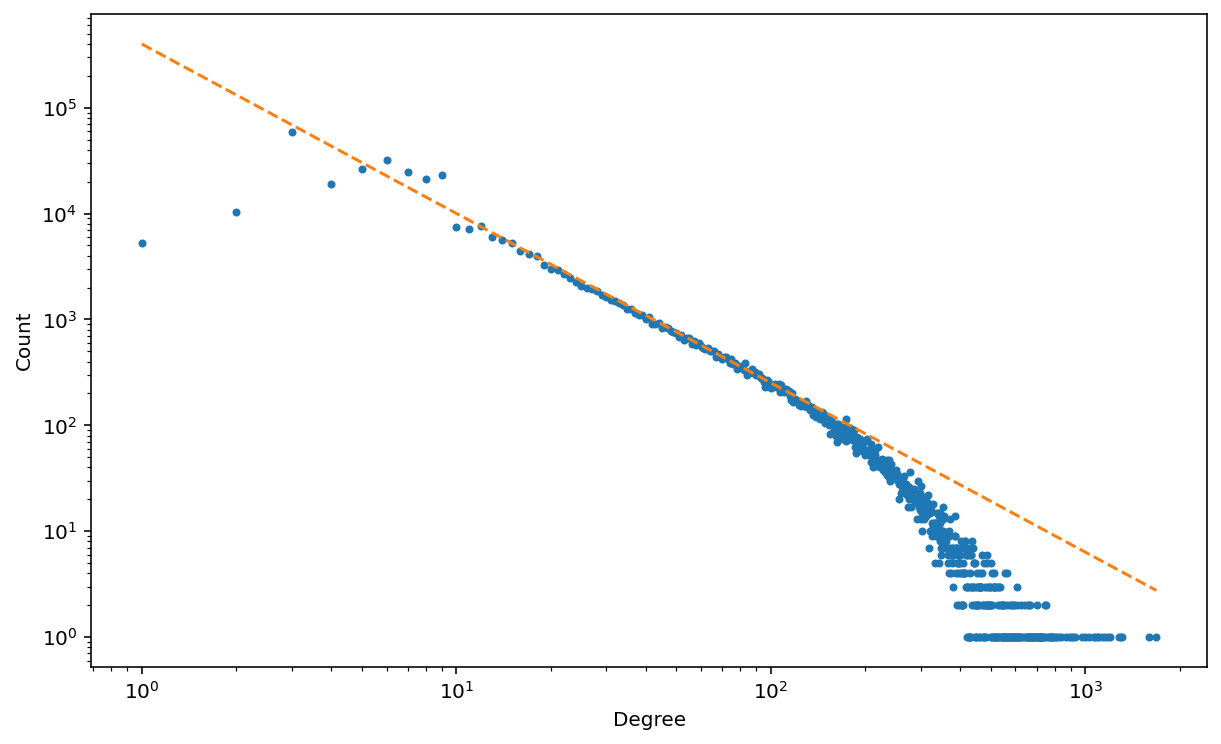

In [ ]:
# Plot the degree distribution

degrees = np.unique(sorted([d for n, d in G.degree()]), return_counts=True)

plt.figure(figsize=(10, 6))
plt.loglog(degrees[0], degrees[1], '.')
# Plot a lines with slope -3 and y-intercept 1e6
plt.loglog(degrees[0], 4e5 / degrees[0]**(1.6), '--')
plt.xlabel('Degree')
plt.ylabel('Count')
plt.show()

In [ ]:
# Print the top 10 most connected actors

raw_actors[raw_actors['nconst'].isin([a for a, d in sorted(G.degree, key=lambda x: x[1], reverse=True)[:10]])]

,nconst,primaryName,birthYear,deathYear,primaryProfession,knownForTitles
464,nm0000465,Ron Jeremy,1953,\N,"actor,director,writer","tt0120577,tt0165710,tt0124819,tt0144117"
560,nm0000561,Peter North,1957,\N,"actor,director,producer","tt0128316,tt0160323,tt0199096,tt0183057"
998,nm0001000,Tom Byron,1961,\N,"actor,director,producer","tt0151056,tt0097039,tt0178845,tt2059288"
96862,nm0101570,T.T. Boy,1968,\N,"actor,director,producer","tt2090472,tt0123532,tt0123632,tt0389276"
122667,nm0128880,Sharon Kane,1956,\N,"actress,miscellaneous,composer","tt1161967,tt0290610,tt0183889,tt0284080"
130391,nm0136994,Macdonald Carey,1913,1994,"actor,soundtrack","tt0058796,tt0039873,tt0036342,tt0043736"
156587,nm0164818,John Clarke,1931,2019,actor,"tt0078622,tt0044259,tt0058796,tt0059678"
241571,nm0254884,James Ellis,1931,2014,"actor,writer","tt0129723,tt0144728,tt0098874,tt0308129"
258843,nm0273077,Don Fernando,1948,\N,"actor,director,producer","tt0134898,tt0271377,tt1067061,tt6536650"
342992,nm0362443,Dave Hardman,1960,\N,"actor,director","tt1556937,tt0234453,tt0408125,tt0280887"


In [ ]:
# Get all the actors in the episode

episode_actors = starring[starring['tconst'] == episode_to_titleId[episode]]['nconst'].unique()
raw_actors[raw_actors['nconst'].isin(episode_actors)]

,nconst,primaryName,birthYear,deathYear,primaryProfession,knownForTitles
190,nm0000191,Ewan McGregor,1971,\N,"actor,writer,producer","tt2763304,tt0117951,tt0203009,tt1322269"
203,nm0000204,Natalie Portman,1981,\N,"actress,producer,soundtrack","tt0376541,tt0434409,tt0110413,tt0947798"
552,nm0000553,Liam Neeson,1952,\N,"actor,producer,soundtrack","tt0429493,tt0362269,tt0108052,tt1601913"
5131,nm0005157,Jake Lloyd,1989,\N,"actor,miscellaneous","tt0120915,tt0116705,tt0200172,tt0206113"
